In [94]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from autoencoder import create_encoders, create_conv_encoders, fit_encoders, create_full_model, \
    fit_full_model, create_fc_layers, create_seq_model
from preprocess import load_clean_data, data_stats, plot_samples, plot_avg, plot_ewma, create_features, \
    create_features_labels 
from plots import plot_validation_diagram

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
data = load_clean_data([0, 1])
validation = load_clean_data([3])

In [289]:
#data_stats(data)

In [158]:
#plot_samples(data)

In [159]:
#plot_avg(data[0]['signals'], 400)

In [160]:
#plot_ewma(data[0]['signals'], 400)

### autoencoder data

In [85]:
beats = create_features(data, 784)
x_train_beats, x_test_beats = train_test_split(beats, test_size = 0.2, random_state = 0)

### full model data

In [96]:
lb = LabelBinarizer()
x_train, labels = create_features_labels(data, 784, non_beats_per_beat = 2)
y_train = lb.fit_transform(labels)

x_test, labels = create_features_labels(validation, 784, non_beats_per_beat = 2)
y_test = lb.transform(labels)

In [76]:
x_train.shape, x_test.shape

((24774, 784), (12492, 784))

In [39]:
print(lb.classes_)

['A' 'N' 'NB']


In [97]:
ann = validation[0]['annotations']
sig = validation[0]['signals']

In [160]:
ann[ann['Type'] == 'A']

,Time,Sample,Type
1357,19:21.875,418275,A
1588,22:40.108,489639,A


In [78]:
def print_raport(models):
    d = [(ae, fc, models[ae]['full_models'][fc]['val_acc']) for ae in models.keys() for fc in models[ae]['full_models']]
    df = pd.DataFrame(d, columns=['AE', 'FC', 'val_acc'])
    display(df)

In [129]:
def print_seq_raport(models):
    d = [(m['config']['filters'], m['config']['units'], m['config']['dropout'], m['val_acc']) for m in models]
    df = pd.DataFrame(d, columns=['filters', 'units', 'dropout', 'val_acc'])
    display(df)

In [79]:
def evaluate_full_model(encoder, config, encoder_name, load_prev, epochs = 2):
    models = {}
    for layers_dim in config:
        model_name = str(layers_dim)
        print('Evaluating model with fc:', model_name)
        model = create_full_model(encoder, layers_dim)        
        h = fit_full_model(model, x_train, x_test, y_train, y_test, epochs=epochs, 
                       filename=encoder_name + model_name, load_prev=load_prev, verbose=0)
        models[model_name] = { 'model' : model, 'val_acc' : h.history['val_acc'][-1] }
        plot_validation_diagram(model, lb.classes_, ann, sig,  418275 - 2000, 418275 + 2500)        
        
    return models

In [86]:
def evaluate_nn_models(config, ae_epochs= 1, full_model_epochs = 1, load_prev_ae = True, load_prev_full = True):
    models = {}    
    for layers_dim in config['ae']:
        ae_name = str(layers_dim)
        print('Running autoencoder with config:', ae_name)
        encoders = create_encoders(*layers_dim)        
        h = fit_encoders(encoders, x_train, x_test, epochs=ae_epochs, filename=ae_name + '.h5', 
                         load_prev=load_prev_ae, verbose=0)
        
        full_models = evaluate_full_model(encoders[1], config['fc'], ae_name, load_prev_full, epochs=full_model_epochs)
        models[ae_name] = {'encoders': encoders, 'full_models': full_models}
    print_raport(models)            
    return models

In [81]:
def evaluate_conv_models(config, ae_epochs= 1, full_model_epochs = 1, load_prev_ae = True, load_prev_full = True):
    models = {}   
    ae_name = 'conv_16_8_8'
    print('Running convolution autoencoder with config:', ae_name)
    encoders = create_conv_encoders()    
    h = fit_encoders(encoders, x_train, x_test, epochs=ae_epochs, filename=ae_name + '.h5', load_prev=load_prev_ae, verbose=0)
    full_models = evaluate_full_model(encoders[1], config['fc'], ae_name, load_prev_full, epochs=full_model_epochs)
    models[ae_name] = {'encoders': encoders, 'full_models': full_models}
    print_raport(models)    
    return models

In [131]:
def evaluate_seq_models(config, epochs= 1, load_prev = True):
    models = [] 
    for c in config:
        model_name = str(c)
        print('Running sequential model with config:', model_name)
        model = create_seq_model(filters = c['filters'], units = c['units'], dropout=c['dropout'])
        h = fit_full_model(model, x_train, x_test, y_train, y_test, epochs=epochs, filename=model_name +'.h5', 
                       load_prev=load_prev, verbose=1)
        models.append({ 'model' : model, 'val_acc' : h.history['val_acc'][-1], 'config' : c })
        plot_validation_diagram(model, lb.classes_, ann, sig,  418275 - 2000, 418275 + 2500)   
    
    print_seq_raport(models)    
    return models

Running autoencoder with config: [784, [], 64]


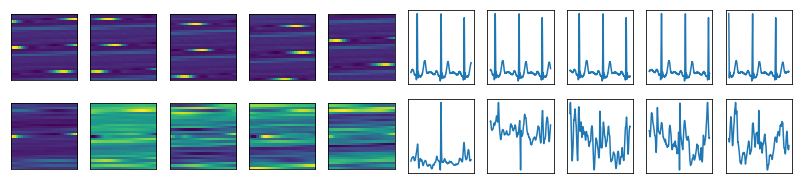

Evaluating model with fc: [3]


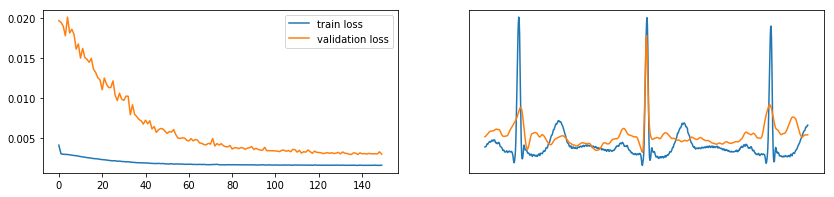

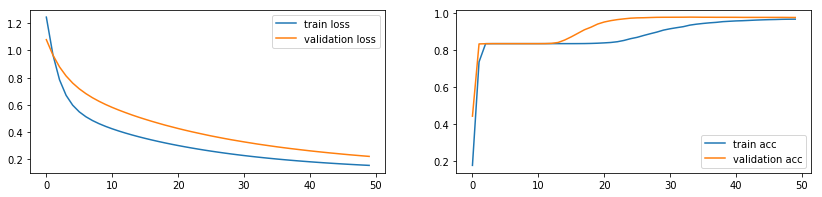

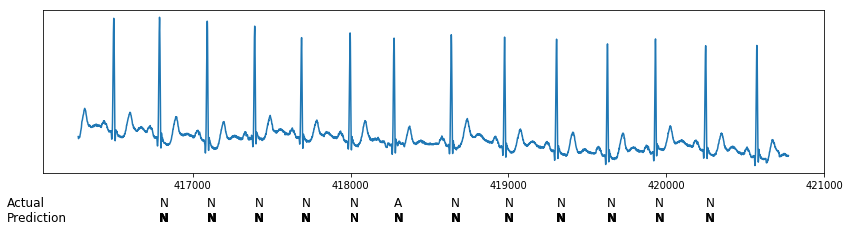

Evaluating model with fc: [32, 3]


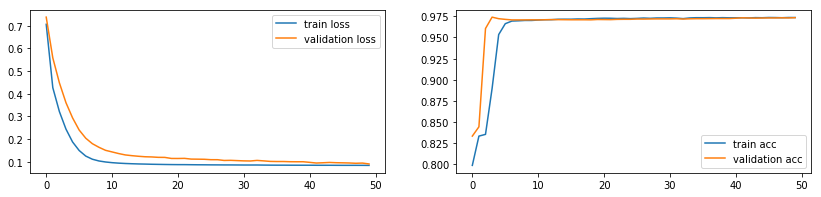

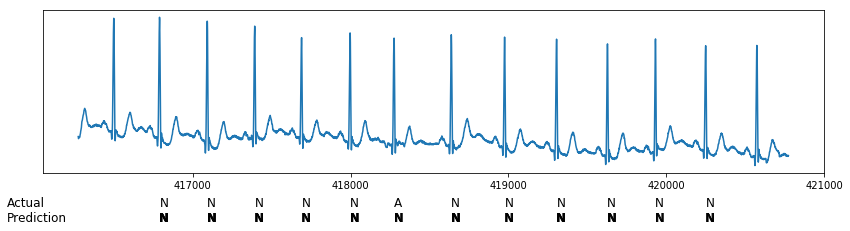

Evaluating model with fc: [64, 3]


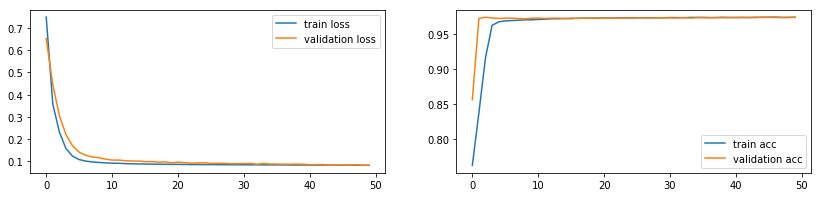

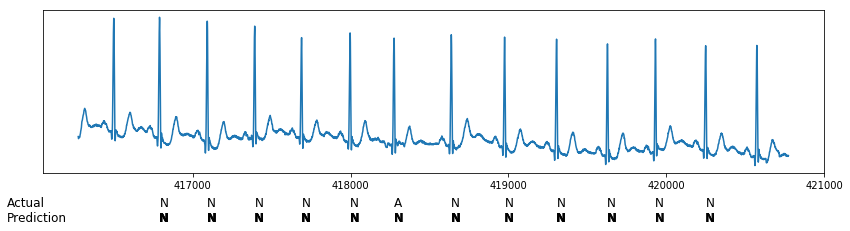

Running autoencoder with config: [784, [256, 128], 64]


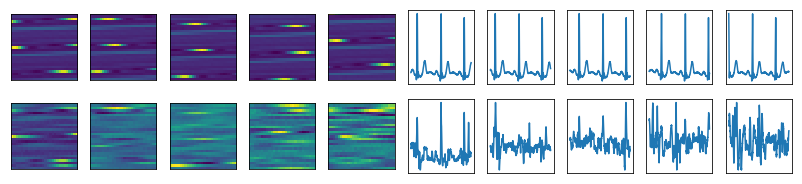

Evaluating model with fc: [3]


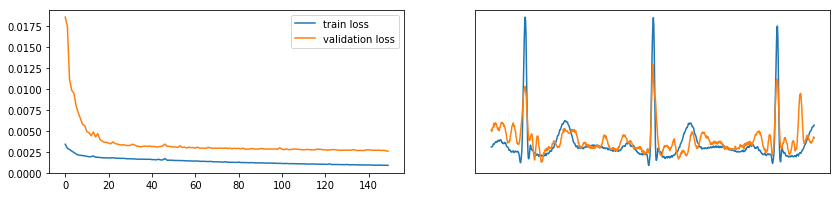

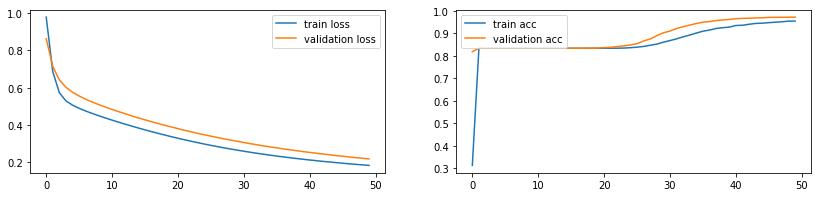

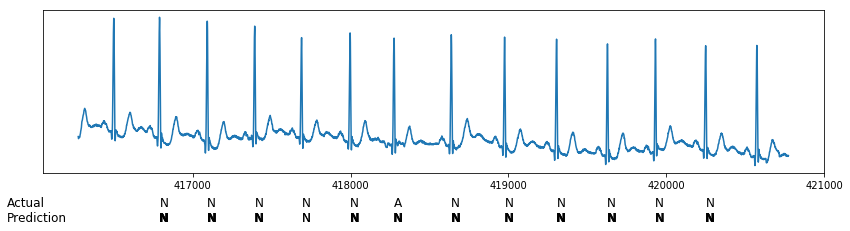

Evaluating model with fc: [32, 3]


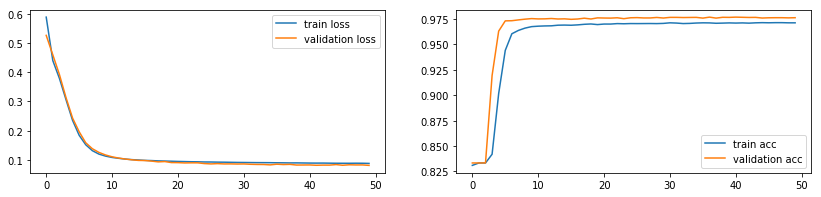

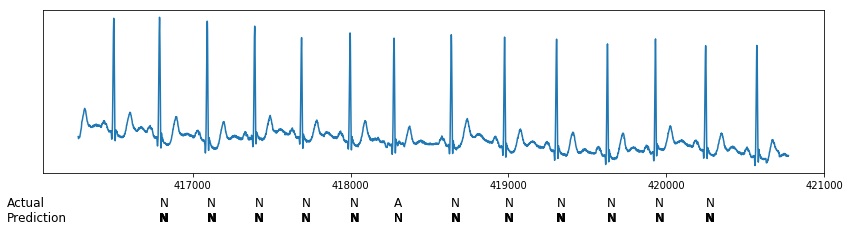

Evaluating model with fc: [64, 3]


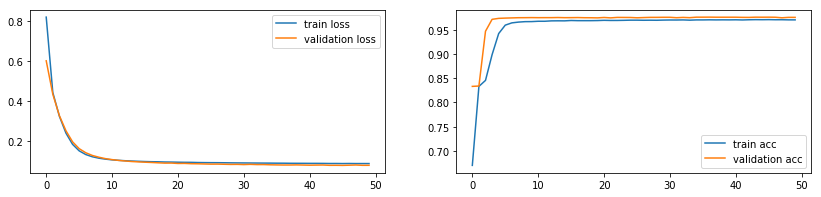

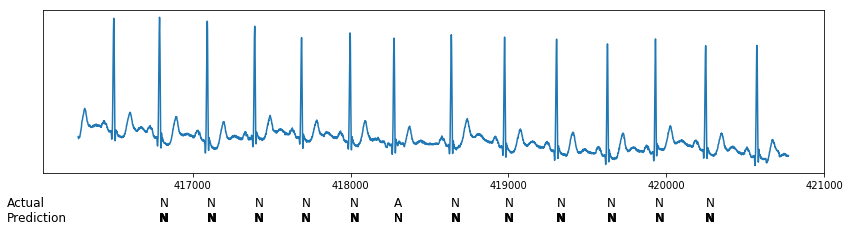

In [82]:
config = {
    'ae' : [ [784,[], 64], [784, [256, 128], 64]],
    'fc' : [ [3], [32,3], [64,3] ]
}
nn_models = evaluate_nn_models(config, 150, 50, load_prev_ae=False, load_prev_full=False)

In [84]:
print_raport(nn_models)

,AE,FC,val_acc
0,"[784, [], 64]",[3],0.974704
1,"[784, [], 64]","[32, 3]",0.973423
2,"[784, [], 64]","[64, 3]",0.973903
3,"[784, [256, 128], 64]",[3],0.971822
4,"[784, [256, 128], 64]","[32, 3]",0.976385
5,"[784, [256, 128], 64]","[64, 3]",0.976305


Running convolution autoencoder with config: conv_16_8_8


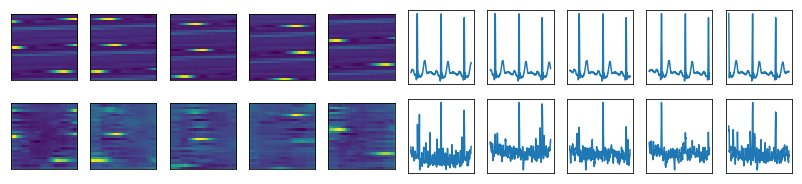

Evaluating model with fc: [3]


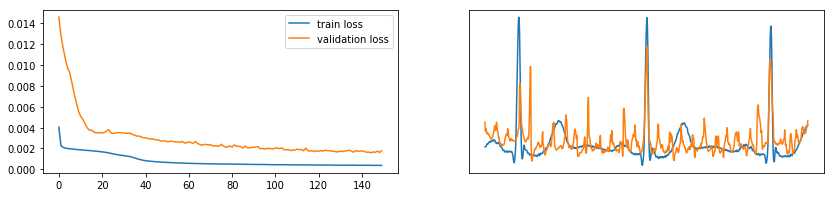

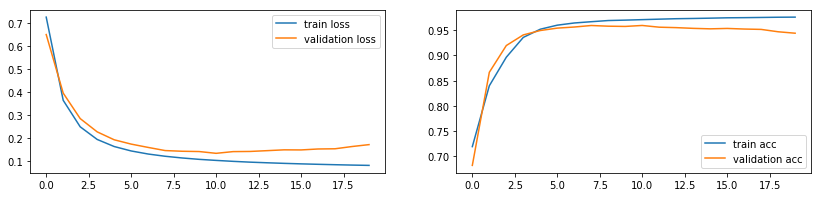

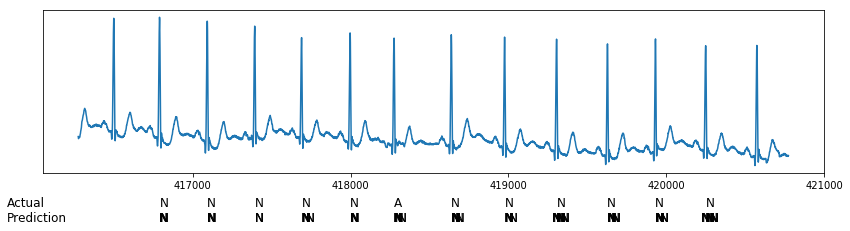

Evaluating model with fc: [64, 3]


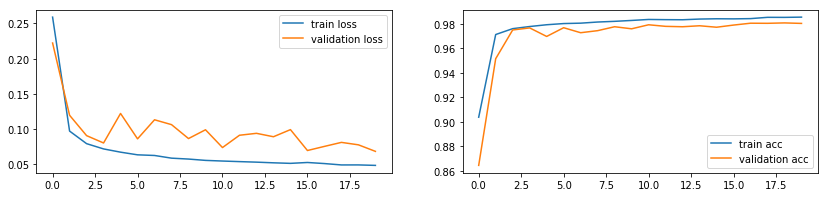

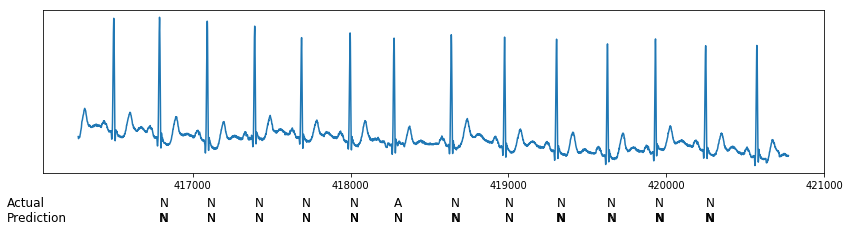

,AE,FC,val_acc
0,conv_16_8_8,[3],0.944364
1,conv_16_8_8,"[64, 3]",0.980387


In [83]:
config = {
    'fc' : [ [3], [64,3] ]
}
conv_models = evaluate_conv_models(config, 150, 20, load_prev_ae=False, load_prev_full=False)

### 784 64

In [784]:
encoders = create_encoders(784, [], 64)

Successfully loaded weights
Train on 12387 samples, validate on 6246 samples
Epoch 1/100
12387/12387 [==============================] - 3s - loss: 0.0035 - acc: 0.0455 - val_loss: 0.0035 - val_acc: 0.0144
Epoch 2/100
12387/12387 [==============================] - 0s - loss: 0.0018 - acc: 0.0421 - val_loss: 0.0032 - val_acc: 0.0251
Epoch 3/100
12387/12387 [==============================] - 0s - loss: 0.0017 - acc: 0.0426 - val_loss: 0.0032 - val_acc: 0.0261
Epoch 4/100
12387/12387 [==============================] - 0s - loss: 0.0017 - acc: 0.0417 - val_loss: 0.0032 - val_acc: 0.0258
Epoch 5/100
12387/12387 [==============================] - 0s - loss: 0.0017 - acc: 0.0411 - val_loss: 0.0032 - val_acc: 0.0261
Epoch 6/100
12387/12387 [==============================] - 0s - loss: 0.0017 - acc: 0.0413 - val_loss: 0.0032 - val_acc: 0.0263
Epoch 7/100
12387/12387 [==============================] - 0s - loss: 0.0017 - acc: 0.0416 - val_loss: 0.0032 - val_acc: 0.0263
Epoch 8/100
12387/12387 [==

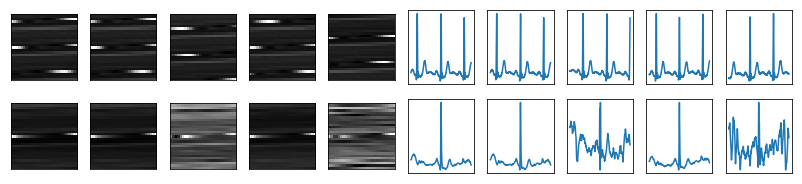

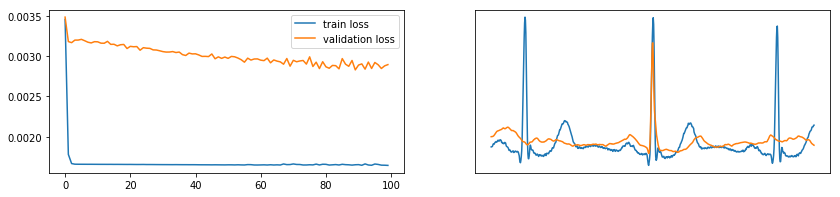

In [787]:
h = fit_encoders(encoders, x_train, x_test, epochs=100, filename='784_64.h5', load_prev=True, verbose=1)

In [85]:
#full_model = create_full_model(encoders[1], layers_dim=[64, 3])
#fit_full_model(full_model, x_train, x_test, y_train, y_test, epochs=100, verbose=0)
#plot_validation_diagram(full_model, lb.classes_, ann, sig, 500, 2500)

(None, 64)
('Evaluating model with fc:', '[3]')
[(None, 784), (None, 64), (None, 3)]


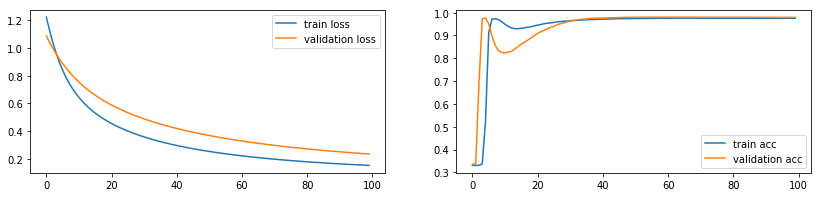

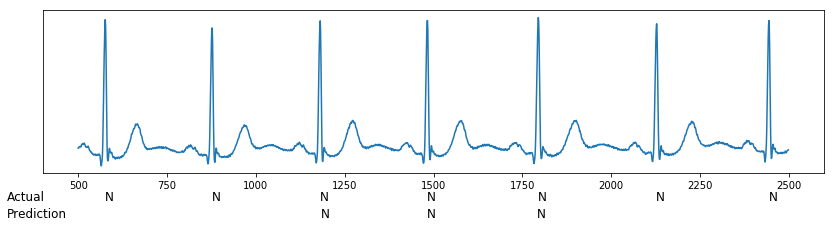

('Evaluating model with fc:', '[10, 3]')
[(None, 784), (None, 64), (None, 10), (None, 3)]


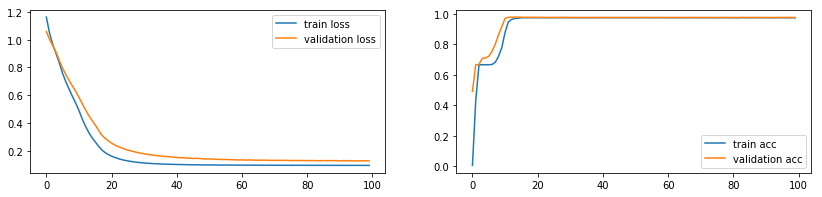

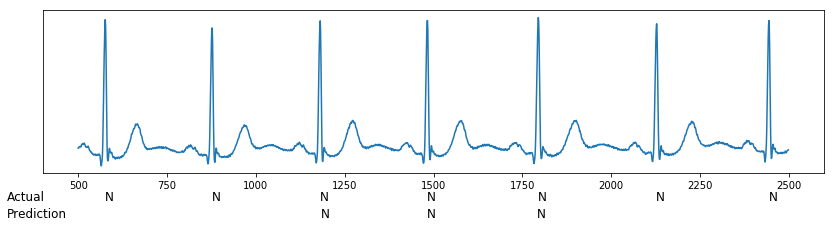

('Evaluating model with fc:', '[32, 3]')
[(None, 784), (None, 64), (None, 32), (None, 3)]


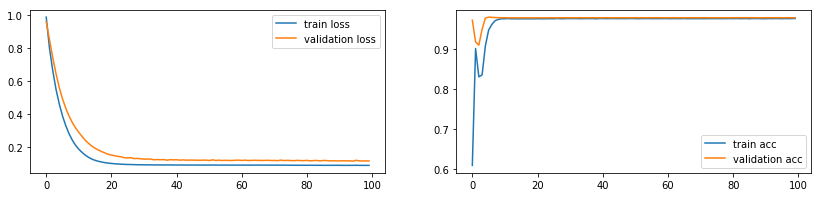

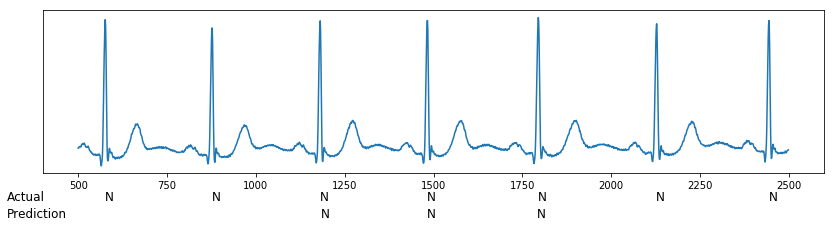

('Evaluating model with fc:', '[64, 3]')
[(None, 784), (None, 64), (None, 64), (None, 3)]


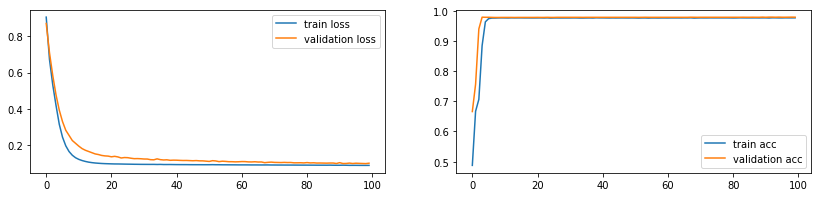

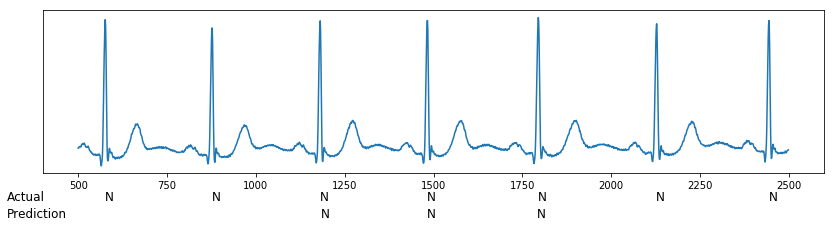

In [788]:
r = evaluate_full_model(encoders[1], [[3], [10,3], [32,3], [64,3]], epochs=100)

### 784 256 128 64

In [792]:
encoders = create_encoders(784, [256, 128], 64)

Train on 12387 samples, validate on 6246 samples
Epoch 1/200
12387/12387 [==============================] - 4s - loss: 0.0031 - acc: 0.0240 - val_loss: 0.0056 - val_acc: 0.0035
Epoch 2/200
12387/12387 [==============================] - 1s - loss: 0.0018 - acc: 0.0480 - val_loss: 0.0050 - val_acc: 0.0016
Epoch 3/200
12387/12387 [==============================] - 1s - loss: 0.0016 - acc: 0.0471 - val_loss: 0.0046 - val_acc: 0.0088
Epoch 4/200
12387/12387 [==============================] - 1s - loss: 0.0015 - acc: 0.0464 - val_loss: 0.0042 - val_acc: 0.0275
Epoch 5/200
12387/12387 [==============================] - 1s - loss: 0.0014 - acc: 0.0509 - val_loss: 0.0040 - val_acc: 0.0285
Epoch 6/200
12387/12387 [==============================] - 1s - loss: 0.0014 - acc: 0.0591 - val_loss: 0.0039 - val_acc: 0.0275
Epoch 7/200
12387/12387 [==============================] - 1s - loss: 0.0014 - acc: 0.0600 - val_loss: 0.0038 - val_acc: 0.0248
Epoch 8/200
12387/12387 [==============================

12387/12387 [==============================] - 2s - loss: 9.1847e-04 - acc: 0.1016 - val_loss: 0.0027 - val_acc: 0.0384
Epoch 127/200
12387/12387 [==============================] - 2s - loss: 9.0119e-04 - acc: 0.1016 - val_loss: 0.0027 - val_acc: 0.0365
Epoch 128/200
12387/12387 [==============================] - 3s - loss: 9.0051e-04 - acc: 0.1015 - val_loss: 0.0028 - val_acc: 0.0411
Epoch 129/200
12387/12387 [==============================] - 2s - loss: 9.1821e-04 - acc: 0.1014 - val_loss: 0.0027 - val_acc: 0.0363
Epoch 130/200
12387/12387 [==============================] - 2s - loss: 9.1693e-04 - acc: 0.1021 - val_loss: 0.0027 - val_acc: 0.0373
Epoch 131/200
12387/12387 [==============================] - 2s - loss: 9.0726e-04 - acc: 0.1004 - val_loss: 0.0026 - val_acc: 0.0376
Epoch 132/200
12387/12387 [==============================] - 2s - loss: 9.0229e-04 - acc: 0.1006 - val_loss: 0.0027 - val_acc: 0.0354
Epoch 133/200
12387/12387 [==============================] - 2s - loss: 9.09

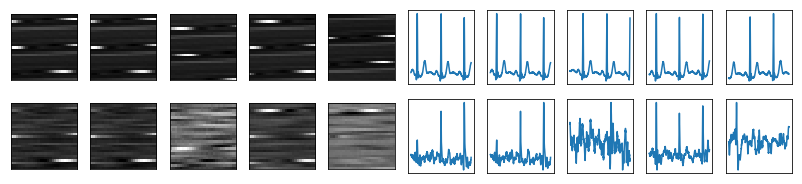

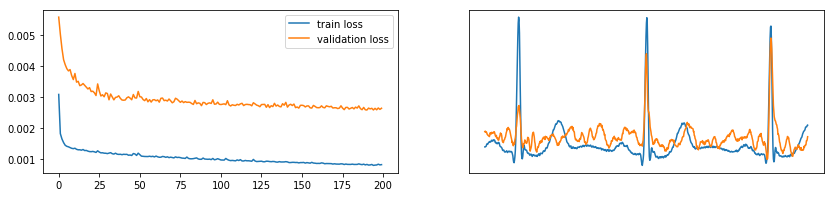

In [796]:
h = fit_encoders(encoders, x_train, x_test, epochs=200, filename='784_256_128_64.h5', load_prev=True, verbose=1)

('Evaluating model with fc:', '[3]')


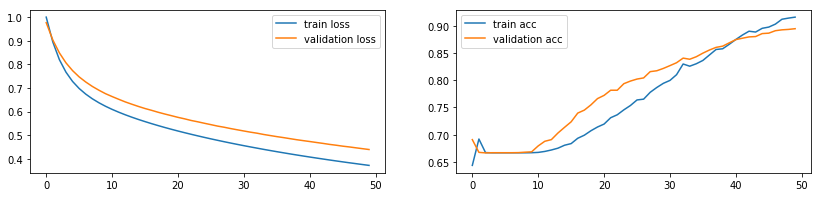

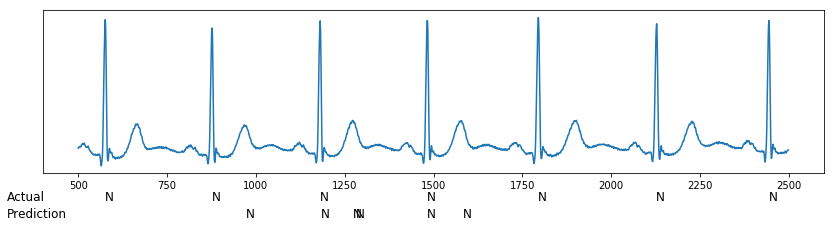

('Evaluating model with fc:', '[10, 3]')


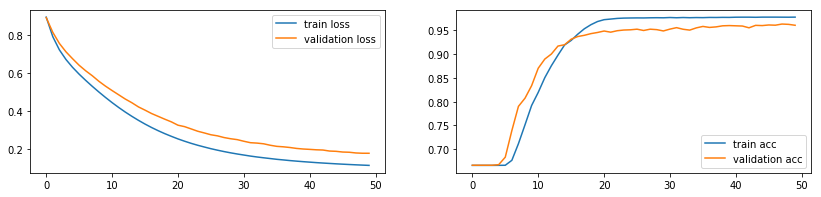

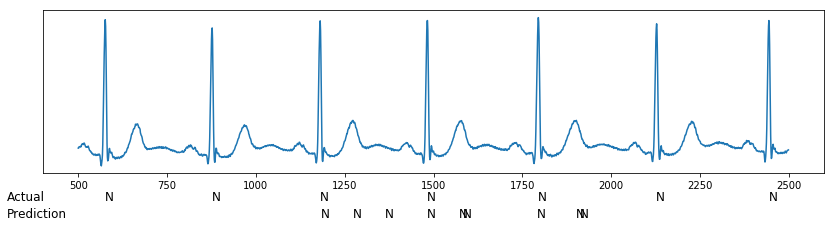

('Evaluating model with fc:', '[32, 3]')


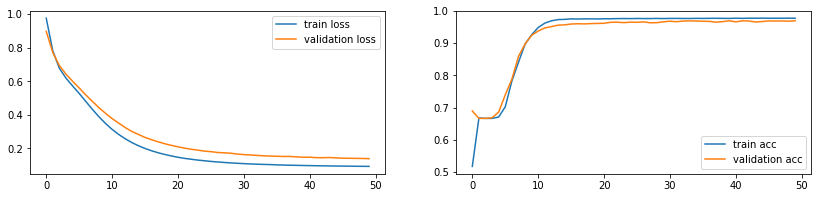

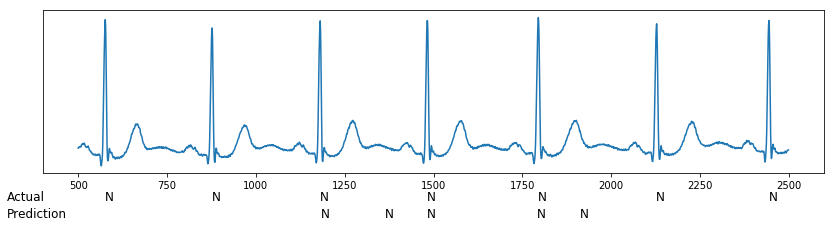

('Evaluating model with fc:', '[64, 3]')


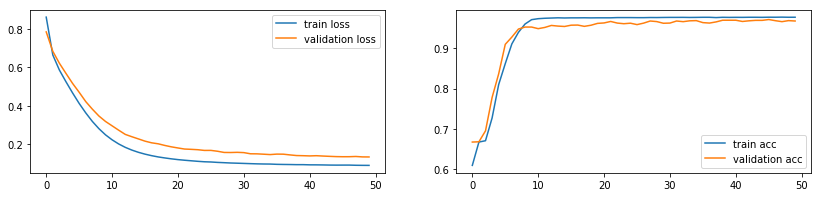

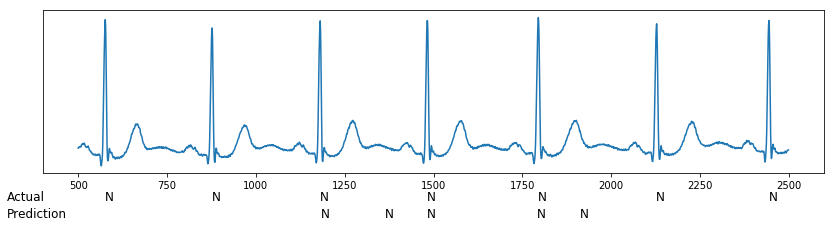

In [797]:
r = evaluate_full_model(encoders[1], [[3], [10,3], [32,3], [64,3]], epochs=50)

### CONV 16, 8, 8

In [775]:
encoders = create_conv_encoders()

("Can't load weights to model", ValueError('You are trying to load a weight file containing 7 layers into a model with 10 layers.',))
Train on 3303 samples, validate on 826 samples
Epoch 1/2
3303/3303 [==============================] - 7s - loss: 0.0094 - acc: 1.1585e-06 - val_loss: 0.0048 - val_acc: 3.0884e-06
Epoch 2/2
3303/3303 [==============================] - 5s - loss: 0.0041 - acc: 2.3170e-06 - val_loss: 0.0050 - val_acc: 3.0884e-06


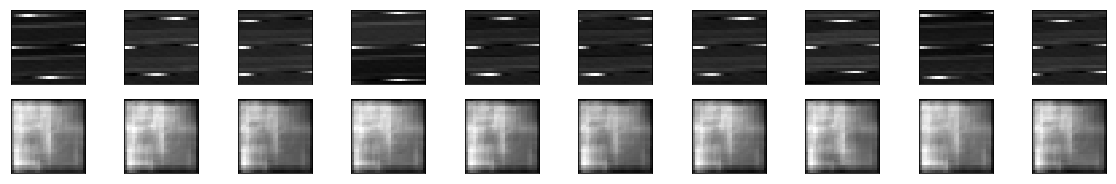

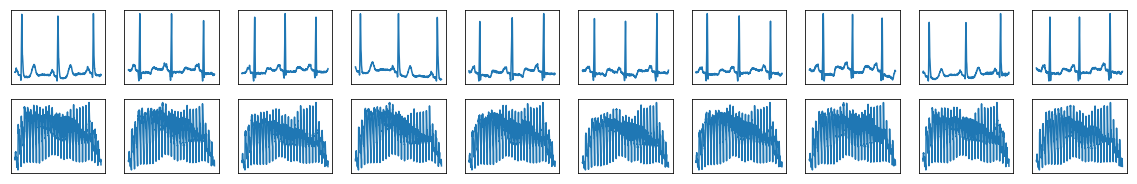

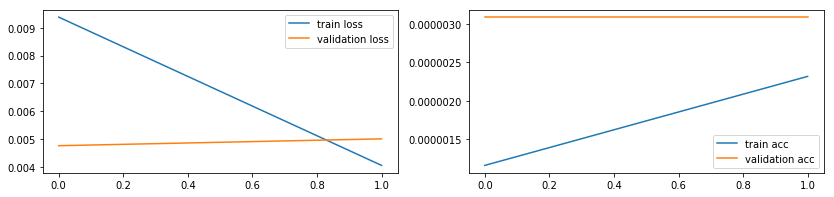

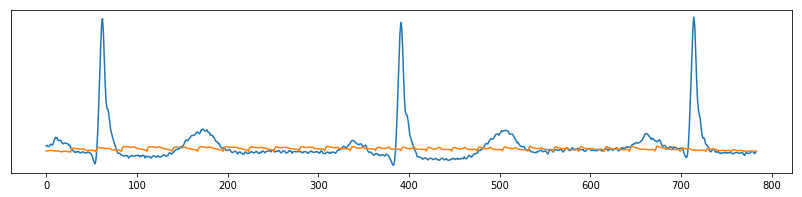

In [776]:
h=fit_encoders(encoders, x_train_beats, x_test_beats, epochs=2, filename='conv16_8_8.h5', load_prev=True, verbose=1)

In [780]:
r = evaluate_full_model(encoders[1], [[3], [10,3], [32,3], [64,3]], epochs=100)

(None, 4, 4, 8)
('Evaluating model with fc:', '[3]')
[(None, 28, 28, 1), (None, 4, 4, 8), (None, 128), (None, 3)]


KeyboardInterrupt: 

### Sequential models

Running sequential model with config: {'filters': [16, 32, 64], 'units': [1024], 'dropout': 0.5}
Successfully loaded weights
Train on 12387 samples, validate on 6246 samples
Epoch 1/5
12387/12387 [==============================] - 4s - loss: 0.0441 - acc: 0.9902 - val_loss: 0.0992 - val_acc: 0.9821
Epoch 2/5
12387/12387 [==============================] - 2s - loss: 0.0438 - acc: 0.9898 - val_loss: 0.1148 - val_acc: 0.9768
Epoch 3/5
12387/12387 [==============================] - 2s - loss: 0.0372 - acc: 0.9918 - val_loss: 0.1685 - val_acc: 0.9672
Epoch 4/5
12387/12387 [==============================] - 2s - loss: 0.0374 - acc: 0.9914 - val_loss: 0.1219 - val_acc: 0.9830
Epoch 5/5
12387/12387 [==============================] - 2s - loss: 0.0352 - acc: 0.9922 - val_loss: 0.1017 - val_acc: 0.9853


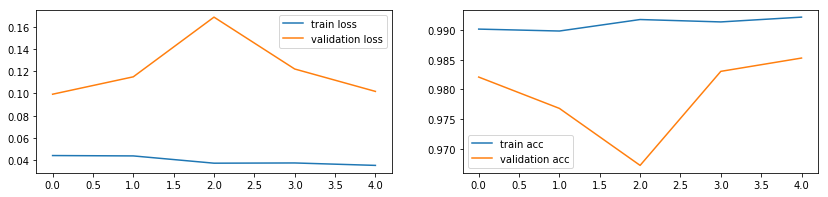

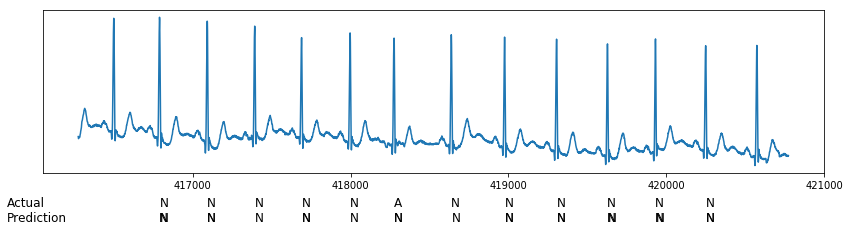

Running sequential model with config: {'filters': [16, 32, 64], 'units': [1024], 'dropout': 0.6}
Successfully loaded weights
Train on 12387 samples, validate on 6246 samples
Epoch 1/5
12387/12387 [==============================] - 4s - loss: 0.0468 - acc: 0.9902 - val_loss: 0.0982 - val_acc: 0.9699
Epoch 2/5
12387/12387 [==============================] - 2s - loss: 0.0435 - acc: 0.9900 - val_loss: 0.0652 - val_acc: 0.9867
Epoch 3/5
12387/12387 [==============================] - 2s - loss: 0.0390 - acc: 0.9919 - val_loss: 0.0605 - val_acc: 0.9854
Epoch 4/5
12387/12387 [==============================] - 2s - loss: 0.0413 - acc: 0.9910 - val_loss: 0.0709 - val_acc: 0.9846
Epoch 5/5
12387/12387 [==============================] - 2s - loss: 0.0367 - acc: 0.9921 - val_loss: 0.0677 - val_acc: 0.9882


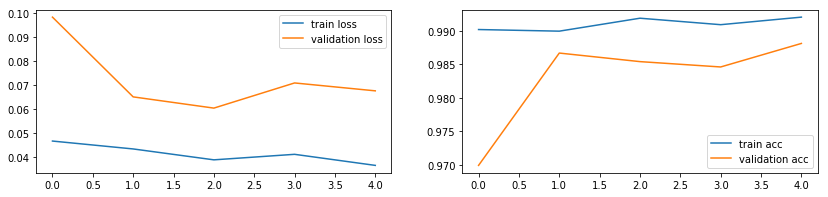

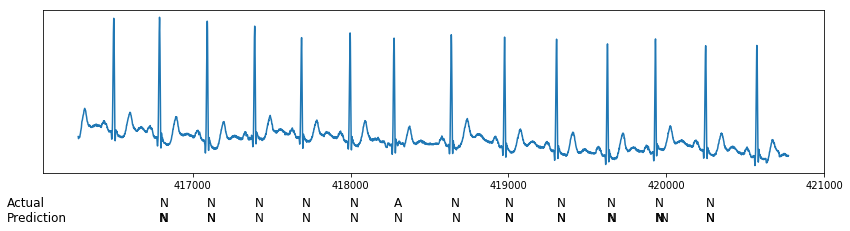

Running sequential model with config: {'filters': [32, 64, 128], 'units': [1024], 'dropout': 0.5}
Successfully loaded weights
Train on 12387 samples, validate on 6246 samples
Epoch 1/5
12387/12387 [==============================] - 6s - loss: 5.3727 - acc: 0.6667 - val_loss: 5.3727 - val_acc: 0.6667
Epoch 2/5
12387/12387 [==============================] - 4s - loss: 5.3727 - acc: 0.6667 - val_loss: 5.3727 - val_acc: 0.6667
Epoch 3/5
12387/12387 [==============================] - 4s - loss: 5.3727 - acc: 0.6667 - val_loss: 5.3727 - val_acc: 0.6667
Epoch 4/5
12387/12387 [==============================] - 4s - loss: 5.3727 - acc: 0.6667 - val_loss: 5.3727 - val_acc: 0.6667
Epoch 5/5
12387/12387 [==============================] - 4s - loss: 5.3727 - acc: 0.6667 - val_loss: 5.3727 - val_acc: 0.6667


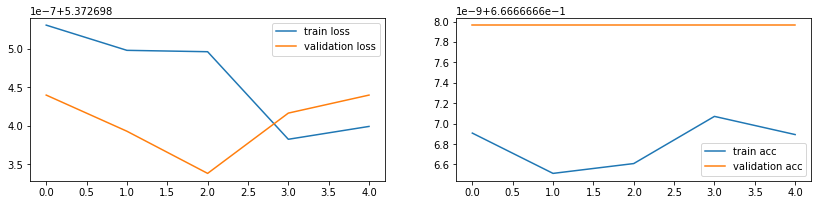

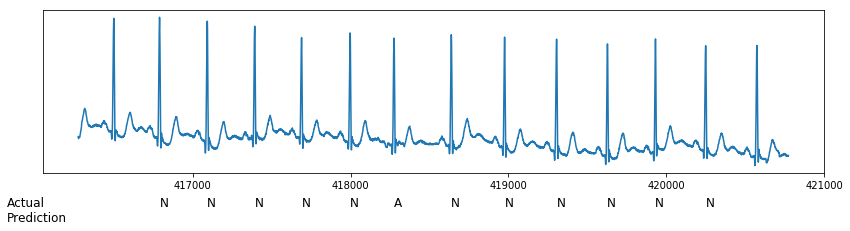

Running sequential model with config: {'filters': [32, 64, 128], 'units': [2048], 'dropout': 0.5}
Successfully loaded weights
Train on 12387 samples, validate on 6246 samples
Epoch 1/5
12387/12387 [==============================] - 6s - loss: 0.0915 - acc: 0.9837 - val_loss: 0.1343 - val_acc: 0.9822
Epoch 2/5
12387/12387 [==============================] - 5s - loss: 0.0460 - acc: 0.9905 - val_loss: 0.1592 - val_acc: 0.9806
Epoch 3/5
12387/12387 [==============================] - 4s - loss: 0.0460 - acc: 0.9909 - val_loss: 0.1951 - val_acc: 0.9755
Epoch 4/5
12387/12387 [==============================] - 4s - loss: 0.0415 - acc: 0.9917 - val_loss: 0.5841 - val_acc: 0.8671
Epoch 5/5
12387/12387 [==============================] - 4s - loss: 0.0403 - acc: 0.9921 - val_loss: 0.2135 - val_acc: 0.9464


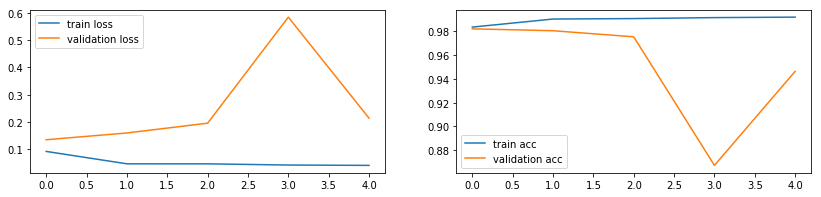

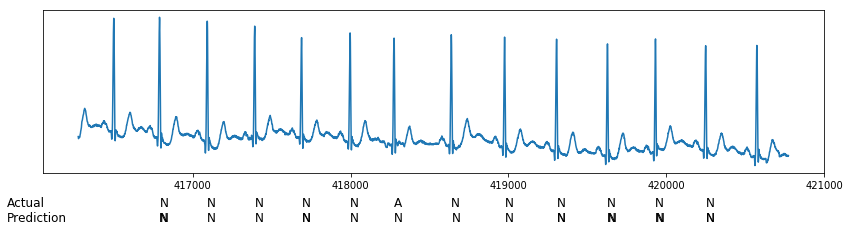

,filters,units,dropout,val_acc
0,"[16, 32, 64]",[1024],0.5,0.985271
1,"[16, 32, 64]",[1024],0.6,0.988152
2,"[32, 64, 128]",[1024],0.5,0.666667
3,"[32, 64, 128]",[2048],0.5,0.946366


In [133]:
config = [
    {'filters' : [16, 32, 64], 'units': [1024], 'dropout': 0.5},
    {'filters' : [16, 32, 64], 'units': [2048], 'dropout': 0.5}    
    {'filters' : [16, 32, 64, 128], 'units': [1024], 'dropout': 0.5}}
]
models = evaluate_seq_models(config, epochs = 5, load_prev=True)

In [ ]:
data = load_clean_data([0, 1])
validation = load_clean_data([3])
lb = LabelBinarizer()
x_train, labels = create_features_labels(data, 784, non_beats_per_beat = 2)
y_train = lb.fit_transform(labels)

x_test, labels = create_features_labels(validation, 784, non_beats_per_beat = 2)
y_test = lb.transform(labels)